<a href="https://colab.research.google.com/github/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/EDA_Medical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Metric Used**

Here we will be using [BLEU](https://towardsdatascience.com/bleu-bilingual-evaluation-understudy-2b4eab9bcfd1) score as  the metric. BLEU score compares each word in the predicted sentence and compare it to the reference sentence (It is also done in n-grams) and returns score based on how many words were predicted that were in the original sentence. BLEU score is not a good metric to compare the performance of translation since simililar words that have the same meaning will be penalized. So we will not only use n-gram BLEU score but also take a sample of the predicted captions and compare it to the original reference caption manually. 

# **Dataset Used**
Here I will be taking a publicly available dataset from Indiana University which consists of chest X-ray [images](https://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d) and [reports](https://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9) (in XML format) which contain information regarding the findings and impression of the X-ray. The goal is to predict the impressions of the medical report attached to the images.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
# from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm

# **Exploratory Data Analysis**

## **Images**

In [2]:
image_folder = 'NLMCXR_png' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 7471


We can see 3 sample images of the dataset. These are chest X_rays which are taken in  front and side view.

## **Reports**

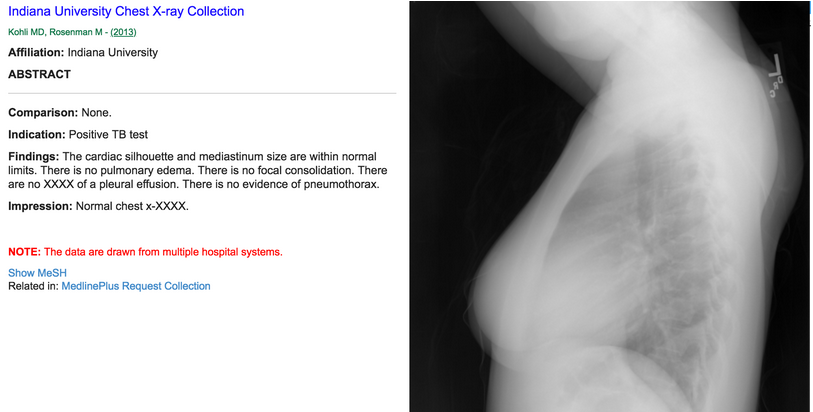

This is  a sample report. The report is stored in xml format. We will extract comparison, indication,findings and impression part of the report.

In [3]:
reports_folder = "ecgen-radiology"

total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 3955


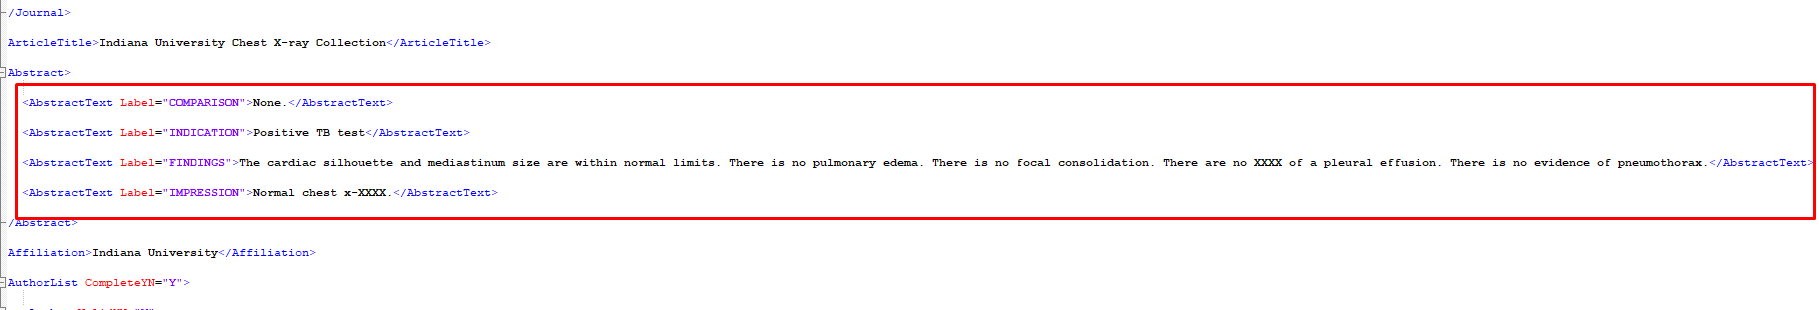

In the xml file, report information is stored like this.

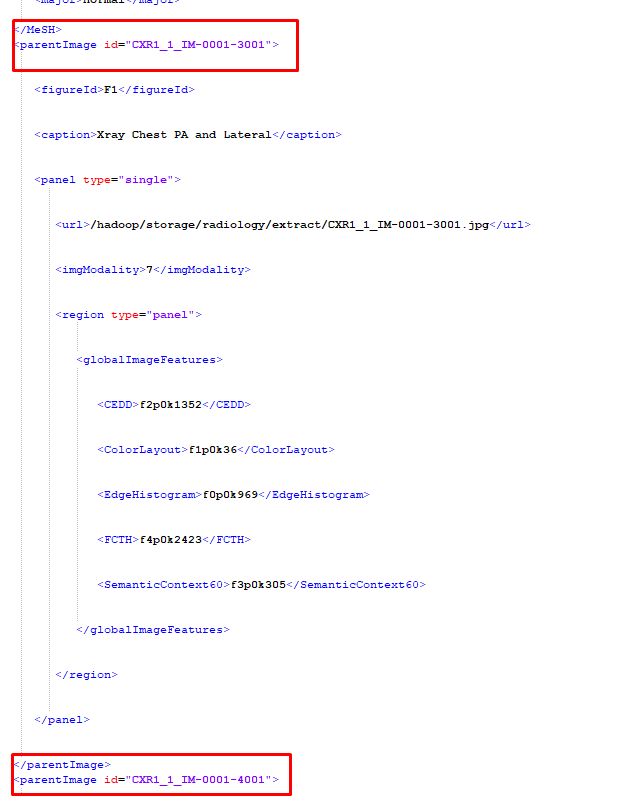

These are the two image files that are associated with this report.
Now we will see what is the maximum and minimum possible value for number of images that are associated with a report.

In [4]:
no_images = [] #stores the no. of images
for file in os.listdir(reports_folder):
  report_file = os.path.join(reports_folder,file)
  with open(report_file, 'r') as f:  #reading the xml data
    data = f.read()
  regex = r"parentImage id.*" #getting all the image names
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)

In [5]:
no_images = np.array(no_images)
print("The max no. of images found associated with a report: %i"%(no_images.max()))
print("The min no. of images found associated with a report: %i"%(no_images.min()))

The max no. of images found associated with a report: 5
The min no. of images found associated with a report: 0


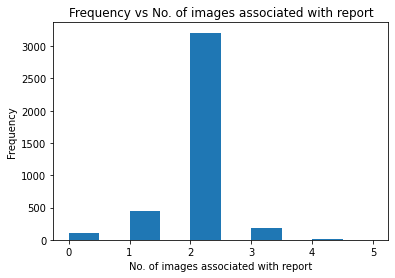

Image Value_counts

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


In [6]:
plt.figure(figsize = (6,4))
ax = pd.Series(no_images).plot(kind='hist')
ax.set_xlabel('No. of images associated with report')
ax.set_title("Frequency vs No. of images associated with report")
plt.show()
print("Image Value_counts\n")
print(pd.Series(no_images).value_counts())

We can see that the maximum number of images associated with a report can be 5 while the minimum is 0. We will extract all the information part ie comparison, indication, findings and impression part of the report and the corresponding 2 images (we will take 2 images as input as 2 images are highest frequecy of being associated with a report) of the concerned report to a dataframe with xml report file name. For images more than 2, we will creat new datapoint with new image and same info.

In [7]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: 
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

In [8]:
%%time
df = get_df()

100%|██████████| 3955/3955 [00:00<00:00, 7590.73it/s]

CPU times: user 493 ms, sys: 35.9 ms, total: 529 ms
Wall time: 528 ms


In [9]:
df.to_pickle("df.pkl")
df = pd.read_pickle("df.pkl")
df.shape

(4169, 7)

In [10]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR2593_IM-1084-1001.png,CXR2593_IM-1084-2001.png,NaN,back pain,mild cardiomegaly is unchanged . stable superi...,mild cardiomegaly with interstitial prominence...,2593.xml
1,CXR2201_IM-0811-1002.png,NaN,two view chest radiograph dated,year old female with tobacco use loss .,bilateral calcified granulomas stable compared...,no acute cardiopulmonary abnormality . .,2201.xml
2,CXR1569_IM-0372-1001.png,CXR1569_IM-0372-2001.png,NaN,the patient s physical . smoking history .,the lungs are clear . there is no pleural effu...,no acute pulmonary disease .,1569.xml
3,CXR2173_IM-0786-1001.png,CXR2173_IM-0786-1002.png,pa lateral chest at a .m .,year old female with left hip replacement,cardiac and mediastinal contours are unremarka...,unremarkable chest radiograph . unchanged dege...,2173.xml
4,CXR3987_IM-2041-1001.png,CXR3987_IM-2041-2001.png,chest radiograph on,year old woman with back pain,no acute osseous abnormality . stable scattere...,no acute radiographic cardiopulmonary or osseo...,3987.xml


Now we check for missing values.

In [11]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------
image_1           2.494603
image_2          13.192612
comparison       33.605181
indication        6.308467
findings         13.504438
impression        0.839530
xml file name     0.000000
dtype: float64


We can see that there are many missing values in the data. We could remove all rows where image_1 and impression values are null since they represent below 5% of the total datapoints.

In [12]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))

136 datapoints were removed.
Final no. of datapoints: 4033


We removed 3.2% datapoints in total.

There are missing values in image_2. For that we can use the same image file in image_1. We will also check for image size for both of them.

In [13]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])

CPU times: user 22.5 s, sys: 862 ms, total: 23.4 s
Wall time: 25 s


In [14]:
df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

In [15]:
df.head(2)

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR2593_IM-1084-1001.png,CXR2593_IM-1084-2001.png,NaN,back pain,mild cardiomegaly is unchanged . stable superi...,mild cardiomegaly with interstitial prominence...,2593.xml,420,512,624,512
1,CXR2201_IM-0811-1002.png,CXR2201_IM-0811-1002.png,two view chest radiograph dated,year old female with tobacco use loss .,bilateral calcified granulomas stable compared...,no acute cardiopulmonary abnormality . .,2201.xml,515,512,515,512


In [16]:
df.to_pickle("df_final.pkl")
df = pd.read_pickle("df_final.pkl")
df.shape

(4033, 11)

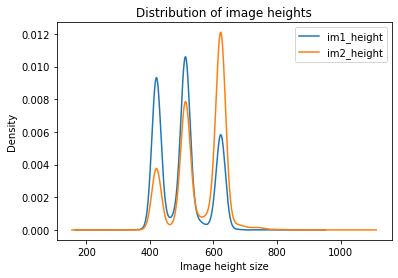



Value Counts of image_1 heights:

420    1130
512     926
624     674
511     234
618      87
Name: im1_height, dtype: int64

 ************************************************** 

Value Counts of image_2 heights:

624    1455
512     714
420     453
511     218
618      89
Name: im2_height, dtype: int64


In [17]:
ax = df[['im1_height','im2_height']].plot(kind='kde')
ax.set_title("Distribution of image heights")
ax.set_xlabel("Image height size")
plt.show()

print("\n\nValue Counts of image_1 heights:\n")
print(df.im1_height.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 heights:\n")
print(df.im2_height.value_counts()[:5])

We can observe that 420 is the most common height for image_1 while for image_2 is 624. The next common for both of the images is 512.

In [18]:
print("Value Counts of image_1 widths:\n")
print(df.im1_width.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 widths:\n")
print(df.im2_width.value_counts()[:5])

Value Counts of image_1 widths:

512    4033
Name: im1_width, dtype: int64

 ************************************************** 

Value Counts of image_2 widths:

512    4033
Name: im2_width, dtype: int64


Width for both of the images have only 1 unique value for all datapoints and that is 512. Since pretrained models are modelled for square-sized images we can choose 512\*512 as the specified size of the image. Hence we can resize all images into 512\*512 shape.

Now we will print some sample datapoints with corresponding images and captions associated with that datapoint.

## **Sample Images + Caption**

In [19]:
def show_image_captions(df = df,image_folder = image_folder,sample = 3):
  """
  given the df, samples datapoints and prints the images and caption
  df: dataframe
  image_folder: folder which contains images
  """
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



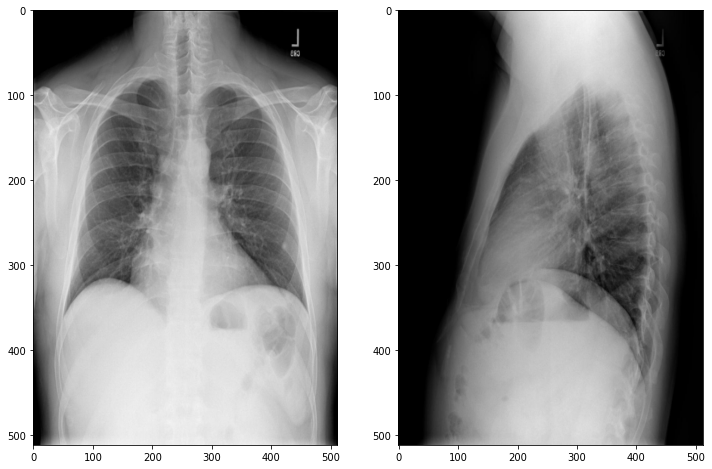


 Comparison:  none .

 Indication:  year old with initiation of medication . ordered for a up prior to beginning the medicine .

 Findings:  the heart pulmonary and mediastinum are within normal limits . there is no pleural effusion or pneumothorax . there is no focal air space opacity to suggest a pneumonia . there is a calcified granuloma in the left lung base .

 Impression:  no acute cardiopulmonary disease . evidence of previous granulomatous infection . 

 ****************************************************************************************************************************************************** 


2)



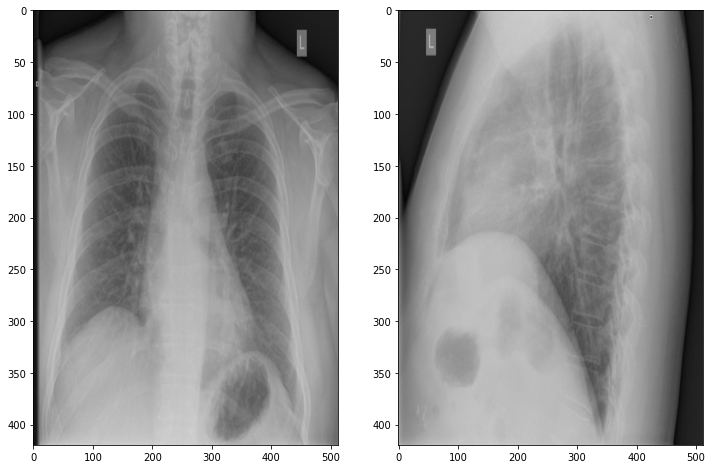


 Comparison:  none

 Indication:  nan

 Findings:  the lungs are clear . the heart and pulmonary are normal . the pleural spaces are clear . mediastinal contours are normal .

 Impression:  no acute cardiopulmonary disease 

 ****************************************************************************************************************************************************** 


3)



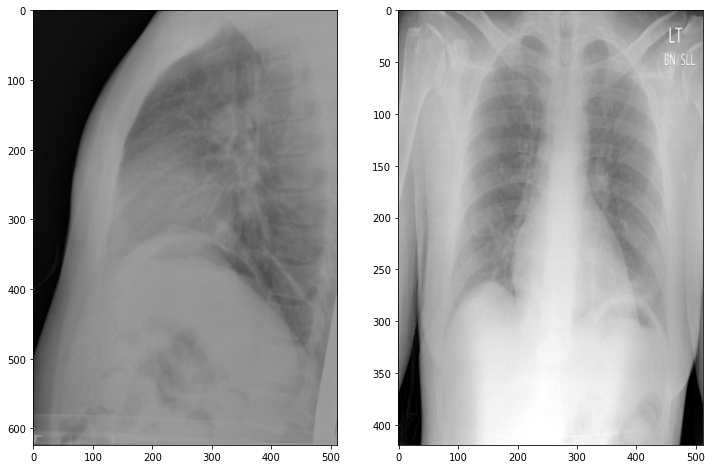


 Comparison:  two view chest from

 Indication:  year old male rule out tuberculosis .

 Findings:  heart size upper limits of normal . small amount of left basilar airspace disease . the right lung is clear . there are no cavitary lesions seen . no pneumothorax . no pleural effusions .

 Impression:  left basilar atelectasis and or infiltrate with no radiographic evidence of tuberculosis . 

 ****************************************************************************************************************************************************** 




In [20]:
#showing sample 3 datapoints
show_image_captions()

We can see that indications are patients medical complaints while findings are the obervations from X-ray while impression is inference obtained. In this case study, I will try to predict the impression part of the medical report given the two images.

### **Wordcloud of Impressions**

In [21]:
#getting wordclouds
#https://www.geeksforgeeks.org/generating-word-cloud-python/
temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

/tmp/ipykernel_674683/3952850811.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable


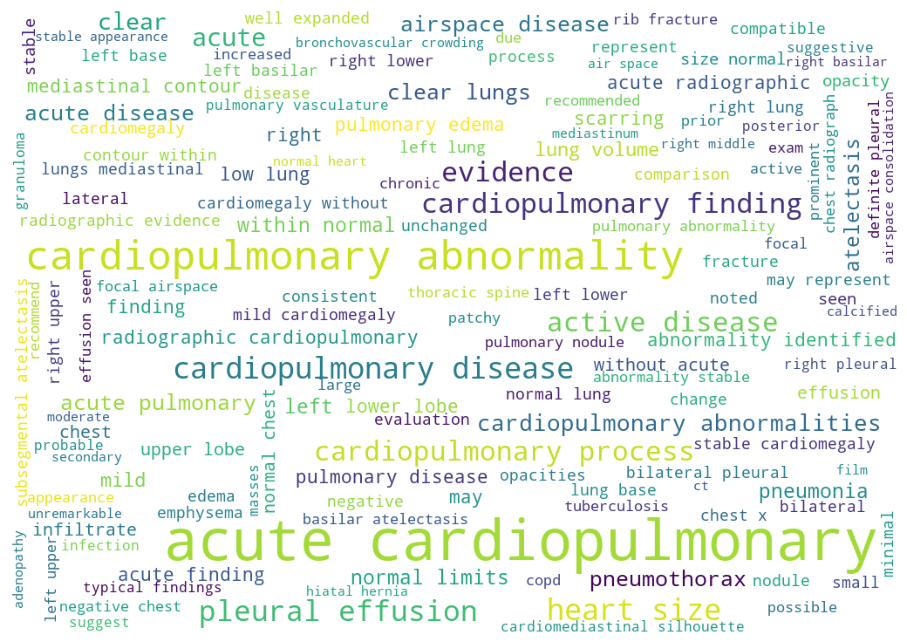

In [22]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()